---
title: "STAT468 Final Project"
author: "Devak Shah"
format: html
toc: true
number-sections: true
jupyter: python3
---

The objective of this project is to investigate the relationship between OHL performance / player build and NHL career longevity. We will analyze how various factors such as goals per game, assists per game, height, and weight influence the probability of a player playing more than 200 games in the NHL.

**CHAPTER 1: IMPORT**

The first step in our project is to import the necessary libraries and data:

In [60]:
import TopDownHockey_Scraper.TopDownHockey_NHL_Scraper as tdhnhlscrape
import TopDownHockey_Scraper.TopDownHockey_EliteProspects_Scraper as tdhepscrape
from nhlpy import NHLClient

In [61]:
import pandas as pd
from datetime import date
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LogisticRegression
from lets_plot import *
LetsPlot.setup_html()

We will create a toggle to see if we want to rescrape the data or just import the prior scrape from an existing file. If `scrape` is set to `True`, we will scrape the data; otherwise, we will read from the existing file.

In [ ]:
scrape = False # Set to True to scrape data, False to use existing data

#This will be the file name where data is stored in our git repo
filename = "regression_input.xlsx"

First, we loop through a bunch of seasons and scrape player OHL stats and builds. Not that we get rid of player positions so that we can join with player builds using names as index. While this is mixing some of steps 2&3 (Tidy&Transform), it's easier to do it here since we want to get the player builds at the time of the draft, and it would be confusing to do the join later on, when we're outside the loop and the stats&builds may not correspond to one another since they could be from seperate years.

In [63]:
#Get OHL Player Data (stats, build, etc)

if scrape == True:

    #Can't include all years because of backend API issues in some years
    years = ["2004-2005", "2006-2007", "2007-2008", "2008-2009", "2009-2010", "2010-2011", "2011-2012", "2012-2013", "2013-2014", 
            "2014-2015", "2015-2016", "2016-2017", "2017-2018", "2018-2019"]

    aggregated_output = pd.DataFrame()

    for year in years:
        df = tdhepscrape.get_skaters(("ohl"), (year))

        #GET PLAYER INFO
        info = tdhepscrape.get_player_information(df)

        #GET RID OF PLAYER POSITIONS FROM NAMES
        df['player'] = df['player'].str.replace(r'\s*\([^)]*\)', '', regex=True)

        #ADD YEAR TO DF
        df.insert(0, "year", year)

        #JOIN PLAYER BIO WITH STATS
        year_output = pd.merge(df[["year", "player", "gp", "g", "a", "tp"]], info[["player", "dob", "height", "weight", "shoots"]], on='player', how='inner')

        #ADD CURRENT YEAR PROSPECTS TO AGGREGATED DF
        aggregated_output = pd.concat([aggregated_output, year_output])


Your scrape request is skater data from the following league:
ohl
In the following season:
2004-2005
Beginning scrape of ohl skater data from 2004-2005.
Successfully scraped all ohl skater data from 2004-2005.
Scraping ohl data is complete. You scraped skater data from 2004-2005.
Completed scraping skater data from the following league:
ohl
Over the following season:
2004-2005
Beginning scrape for 491 players.
Chris Ferguson scraped! That's 1 down! Only 490 left to go!
Thomas Policelli scraped! That's 2 down! Only 489 left to go!
Mark Johnson scraped! That's 3 down! Only 488 left to go!
Chris Hulit scraped! That's 4 down! Only 487 left to go!
Chris Chimienti scraped! That's 5 down! Only 486 left to go!
Tomas Sample scraped! That's 6 down! Only 485 left to go!
Kyle Hope scraped! That's 7 down! Only 484 left to go!
Tom Mannino scraped! That's 8 down! Only 483 left to go!
Trevor Erdie scraped! That's 9 down! Only 482 left to go!
Jeff Kyrzakos scraped! That's 10 down! Only 481 left to go!


Next, we print the draftyears of all NHL players drafted between 2005 and 2020

In [64]:
if scrape == True:
    years = list(range(2005, 2021))

    draftyears = pd.DataFrame()

    for year in years:
        df_list = pd.read_html(f"https://www.hockey-reference.com/draft/NHL_{year}_entry.html", match="Round")

        players_drafted = df_list[0]

        players_drafted

        #Let's get rid of the top header that isnt really used
        players_drafted.columns = players_drafted.columns.get_level_values(1)

        players_drafted["draft_year"] = year
        players_drafted = players_drafted[["draft_year", "Player"]]
        players_drafted =players_drafted.rename(columns={"draft_year": "player_draft_year", "Player": "player"})
        draftyears = pd.concat([draftyears, players_drafted])

    print(draftyears)        

     player_draft_year            player
0                 2005     Sidney Crosby
1                 2005        Bobby Ryan
2                 2005      Jack Johnson
3                 2005    Benoit Pouliot
4                 2005       Carey Price
..                 ...               ...
223               2020     Ryan Tverberg
224               2020   Henrik Tikkanen
225               2020    Maxim Marushev
226               2020     Jakub Konecny
227               2020  Declan McDonnell

[3609 rows x 2 columns]


Finally, we get the games played for all NHL players to have played at least 1 game in the NHL. We will use this to calculate the probability of a player playing more than 200 games in the NHL.

In [66]:
#Getting games played for all NHL players
if scrape == True:
    nhl_gp = pd.DataFrame()
    pages = list(range(1, 80))

    for page in pages:
        df_list = pd.read_html(f"https://www.eliteprospects.com/league/nhl/stats/all-time?page={page}")
        page_stats = df_list[2]
        page_stats = page_stats[["Player", "GP"]]
        nhl_gp = pd.concat([nhl_gp, page_stats])

    nhl_gp = nhl_gp.rename(columns={"Player": "player", "GP": "nhl_gp"})

    #GET RID OF PLAYER POSITIONS FROM NAMES
    nhl_gp['player'] = nhl_gp['player'].str.replace(r'\s*\([^)]*\)', '', regex=True)

    # Replacing NA and "-" values with 0
    nhl_gp["nhl_gp"] = nhl_gp["nhl_gp"].fillna(0)
    nhl_gp["nhl_gp"] = nhl_gp["nhl_gp"].replace("-", 0)

    nhl_gp

**CHAPTER 2: TIDY**

We first get rid of defencemen from our dataset, since we are only concerned with forwards.

In [67]:
if scrape == True:
    aggregated_output = aggregated_output[~aggregated_output['player'].str.contains(r'\(([^)]*D[^)]*)\)', regex=True)]

Next, we change the type of some columns - they are objects by default, we need them to be integeres to regress on them later on.
We also replace "-" values with 0 for regression purposes, since "-" means that the player did not play in that season, and we want to treat that as 0 games played.

In [68]:
if scrape == True:
    aggregated_output["gp"] = aggregated_output["gp"].replace("-", 0)
    aggregated_output["gp"] = aggregated_output["gp"].astype(int)
    aggregated_output["g"] = aggregated_output["g"].replace("-", 0)
    aggregated_output["g"] = aggregated_output["g"].astype(int)
    aggregated_output["a"] = aggregated_output["a"].replace("-", 0)
    aggregated_output["a"] = aggregated_output["a"].astype(int)
    aggregated_output["tp"] = aggregated_output["tp"].replace("-", 0)
    aggregated_output["tp"] = aggregated_output["tp"].astype(int)

Get corresponding draft year for each row in the dataset (oe. season 2024-2025 would have a draft year of 2025).

Note this isn't necessarily the players' draft year - it's just the draft year for the corresponding row's season. We will use this to only keep rows where the draft year is the same as the player's actual draft year.

In [69]:
if scrape == True:
    aggregated_output["draft_year"] = aggregated_output["year"].str[5:]
    aggregated_output["draft_year"] = aggregated_output["draft_year"].astype(int)
    aggregated_output

Join games played and draft year onto each row of the OHL player data dataset.

In [70]:
#Join GP, draft year onto OHL player data
if scrape == True:
    #MAKE ALL PLAYER NAMES UPPERCASE (TO MAKE JOINING TABLES NON CASE SENSITIVE)
    aggregated_output['player'] = aggregated_output['player'].str.upper()
    draftyears['player'] = draftyears['player'].str.upper()
    nhl_gp['player'] = nhl_gp['player'].str.upper()


    #Filter ohl stats for only drafted players' draft year stats - 
    #This will get rid of a) undrafted players, and b) drafted players non-draft year stats
    df = pd.merge(aggregated_output, draftyears, left_on=['player', 'draft_year'], right_on=['player', 'player_draft_year'], how='inner')

    #Can get rid of one of the draft year columns - don't need both
    df = df[["year", "player", "gp", "g", "a", "tp", "dob",	"height", "weight",	"shoots", 'draft_year']]

    #Join players' games played - if player gp not found, assume it to be 0.
    df = pd.merge(df, nhl_gp, left_on=['player'], right_on=['player'], how='left')
    df["nhl_gp"] = df["nhl_gp"].fillna(0)
    df["nhl_gp"] = df["nhl_gp"].astype(int)

    df.to_excel(filename, index=False)

Finally, some miscallaneous tidying. Refer to comments for more information.

In [71]:
df = pd.read_excel(filename)

#Changing the weight to a numerical variate in kg
df["weight_kg"] = df["weight"].apply(lambda x: x[:x.find(" ")])
df["weight_kg"] = df["weight_kg"].astype(int)
df.dtypes

#Can get rid of intermediate columns
df = df.drop(["weight"], axis = 1)

#Renaming height column to height_cm for clarity
df = df.rename(columns = {"height": "height_cm"})
df

,year,player,gp,g,a,tp,dob,height_cm,shoots,draft_year,nhl_gp,weight_kg
0,2004-2005,BOBBY RYAN,62,37,52,89,1987-03-17,188,R,2005,866,95
1,2004-2005,DAN RYDER,68,29,53,82,1987-01-12,180,R,2005,0,88
2,2004-2005,CAL O'REILLY,68,23,50,73,1986-09-30,183,L,2005,145,85
3,2004-2005,STEVE DOWNIE,61,21,52,73,1987-04-03,180,R,2005,434,87
4,2004-2005,EVAN BROPHEY,63,28,43,71,1986-12-03,185,L,2005,4,92
...,...,...,...,...,...,...,...,...,...,...,...,...
479,2018-2019,MASON MILLMAN,66,3,22,25,2001-07-18,185,L,2019,0,79
480,2018-2019,NIKITA OKHOTYUK,56,2,15,17,2000-12-04,186,L,2019,67,82
481,2018-2019,JACOB LEGUERRIER,68,6,10,16,2000-11-22,185,L,2019,0,92
482,2018-2019,MATHEW HILL,65,2,11,13,2001-05-01,193,L,2019,0,96


**STEP 3: TRANSFORM**

Creating some new stats (age at draft, goals per game, points per game, and an indicator variable for whether the player has played at least 200 NHL games). These will all be used in the regression later on.

In [72]:
#Getting the age of the player at the time of draft (for simplicity, we will assume draft to be on June 30 for all years)
df["draft_date"] = df["draft_year"].astype(str) + '-06-30'
df["draft_date"] = pd.to_datetime(df["draft_date"])
df["dob"] = pd.to_datetime(df["dob"])
df["age_days"] = (df["draft_date"] - df["dob"])
df["age_days"] = df["age_days"].dt.days

#Can get rid of intermediate columns
df = df.drop(["draft_date", "draft_year", "dob"], axis = 1)

#Adding columns for goals/g and points/g
df["gpg"] = df["g"] / df["gp"]
df["ppg"] = df["tp"] / df["gp"]

#Create indicator variable to measure if the player has played at least 200 nhl games
df["Pr[GP > 200]"] = df["nhl_gp"] >= 200
df["Pr[GP > 200]"] = df["Pr[GP > 200]"].astype(int)

df

,year,player,gp,g,a,tp,height_cm,shoots,nhl_gp,weight_kg,age_days,gpg,ppg,Pr[GP > 200]
0,2004-2005,BOBBY RYAN,62,37,52,89,188,R,866,95,6680,0.596774,1.435484,1
1,2004-2005,DAN RYDER,68,29,53,82,180,R,0,88,6744,0.426471,1.205882,0
2,2004-2005,CAL O'REILLY,68,23,50,73,183,L,145,85,6848,0.338235,1.073529,0
3,2004-2005,STEVE DOWNIE,61,21,52,73,180,R,434,87,6663,0.344262,1.196721,1
4,2004-2005,EVAN BROPHEY,63,28,43,71,185,L,4,92,6784,0.444444,1.126984,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2018-2019,MASON MILLMAN,66,3,22,25,185,L,0,79,6556,0.045455,0.378788,0
480,2018-2019,NIKITA OKHOTYUK,56,2,15,17,186,L,67,82,6782,0.035714,0.303571,0
481,2018-2019,JACOB LEGUERRIER,68,6,10,16,185,L,0,92,6794,0.088235,0.235294,0
482,2018-2019,MATHEW HILL,65,2,11,13,193,L,0,96,6634,0.030769,0.200000,0


**STEP 4: VISUALIZE**

We will create 2 visualizations, to investiage whether certain variates are correlated with the probability of a player playing more than 200 games in the NHL.

- The first visualization will be a scatterplot of goals per game in the OHL vs. NHL games played, colored by points per game.

- The second visualization will be a scatterplot of height of players in the OHL vs. NHL games played, colored by weight in kg.

In [73]:
(
    ggplot(
      data = df,
      mapping = aes(
        x = "gpg", y = "nhl_gp", color = "ppg"
      )
    ) +
      geom_point() +
      labs(color = "ppg")
)

In [74]:
(
    ggplot(
      data = df,
      mapping = aes(
        x = "height_cm", y = "nhl_gp", color = "weight_kg"
      )
    ) +
      geom_point() +
      labs(color = "weight_kg")
)

We can see a little bit or correlation in both graphs. In the nwxt step, we will use regression to try and come with a better model that better quanitifies the impact of multiple variables on the probability of a player playing more than 200 games in the NHL.

**STEP 5: MODEL**

We are going to create a logistic regression model. Logsitic regression is used since we are regressing for a probability, which needs to be bounded between 0 and 1. The model will aim to predict the probability a player becoming an everyday NHL player (play 200 NHL games or more):

In [75]:
# X: predictors, y: binary response
df_regress = df[df["year"].isin(["2004-2005", "2006-2007", "2007-2008", "2008-2009", "2009-2010", 
                                 "2014-2015", "2015-2016", "2016-2017", "2017-2018", "2018-2019"])]
X = df_regress[['tp', 'height_cm', 'weight_kg', 'age_days', 'gpg', 'ppg']]
X = sm.add_constant(X)  # adds intercept
y = df_regress['Pr[GP > 200]']

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.499010
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           Pr[GP > 200]   No. Observations:                  342
Model:                          Logit   Df Residuals:                      335
Method:                           MLE   Df Model:                            6
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                  0.1670
Time:                        11:06:59   Log-Likelihood:                -170.66
converged:                       True   LL-Null:                       -204.87
Covariance Type:            nonrobust   LLR p-value:                 8.634e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5223      6.970     -0.362      0.717     -16.183      11.139
tp            -0.0191      0.

The p-values tell us that ...

**STEP 6: COMMUNICATE**

Let's first look at if there is multicollinearity in our data:

In [76]:
print(X.corr())

           const        tp  height_cm  weight_kg  age_days       gpg       ppg
const        NaN       NaN        NaN        NaN       NaN       NaN       NaN
tp           NaN  1.000000  -0.395947  -0.248431  0.136841  0.866653  0.971189
height_cm    NaN -0.395947   1.000000   0.686994 -0.040244 -0.330728 -0.390674
weight_kg    NaN -0.248431   0.686994   1.000000  0.026386 -0.194471 -0.241021
age_days     NaN  0.136841  -0.040244   0.026386  1.000000  0.117457  0.130188
gpg          NaN  0.866653  -0.330728  -0.194471  0.117457  1.000000  0.887031
ppg          NaN  0.971189  -0.390674  -0.241021  0.130188  0.887031  1.000000


Now, we will test out our model on a test set. We will use the model to predict the probability of a player becoming an everyday NHL player (playing 200 or more NHL games). We will do so on seasons we did not train our model on.

In [77]:
#Testing model out
df_test = df[df["year"].isin(["2010-2011", "2011-2012", "2012-2013", "2013-2014"])]
X = df_test[['tp', 'height_cm', 'weight_kg', 'age_days', 'gpg', 'ppg']]
X = sm.add_constant(X, has_constant='add')  # adds intercept

#If regression yields a probability greater than or equal to 0.5, we will say it predicts the player will become a full-time NHL player
df_test["pred_prob"] = result.predict(X) >= 0.5
df_test

,year,player,gp,g,a,tp,height_cm,shoots,nhl_gp,weight_kg,age_days,gpg,ppg,Pr[GP > 200],pred_prob
187,2010-2011,RYAN STROME,65,33,73,106,185,R,864,87,6563,0.507692,1.630769,1,True
188,2010-2011,SHANE PRINCE,59,25,63,88,181,L,128,88,6800,0.423729,1.491525,0,True
189,2010-2011,RYAN MURPHY,63,26,53,79,180,R,175,83,6665,0.412698,1.253968,0,True
190,2010-2011,STEFAN NOESEN,68,34,43,77,185,R,444,93,6712,0.500000,1.132353,1,False
191,2010-2011,ANDY ANDREOFF,66,33,42,75,185,L,188,95,7349,0.500000,1.136364,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,2013-2014,CHRISTIAN DVORAK,33,6,8,14,185,L,534,91,6723,0.181818,0.424242,1,False
325,2013-2014,KYLE WOOD,33,2,10,12,200,R,0,101,6631,0.060606,0.363636,0,False
326,2013-2014,KYLE PETTIT,53,5,5,10,193,L,0,91,6737,0.094340,0.188679,0,False
327,2013-2014,JOSH WESLEY,68,2,7,9,191,R,0,94,6656,0.029412,0.132353,0,False


Next, we will look at model accuracy. We will use TP, TN, FP, FN to calculate accuracy.

Finally, we will look at the ROC curve and AUC to evaluate the model's performance.

In [78]:
TP = df_test[(df_test["Pr[GP > 200]"] == True) & (df_test["pred_prob"] == True)].shape[0]
print(f"True Positive: {TP}")

TN = df_test[(df_test["Pr[GP > 200]"] == False) & (df_test["pred_prob"] == False)].shape[0]
print(f"True Negative: {TN}")

FP = df_test[(df_test["Pr[GP > 200]"] == False) & (df_test["pred_prob"] == True)].shape[0]
print(f"False Positive: {FP}")

FN = df_test[(df_test["Pr[GP > 200]"] == True) & (df_test["pred_prob"] == False)].shape[0]
print(f"False Negative: {FN}")

accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
print(f"Accuracy: {accuracy:.2%}")

true_positive_rate = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"True Positive Rate: {true_positive_rate:.2%}")

true_negative_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
print(f"True Negative Rate: {true_negative_rate:.2%}")

True Positive: 12
True Negative: 90
False Positive: 4
False Negative: 36
Accuracy: 71.83%
True Positive Rate: 25.00%
True Negative Rate: 4.26%


We will also use ROC curve to look at the TPR, FPR of different thresholds. We can calculate AUR from this to measure accuracy of model considering all thresholds (AUS = 1 means perfect model, AUS = 0.5 means random guessing).:

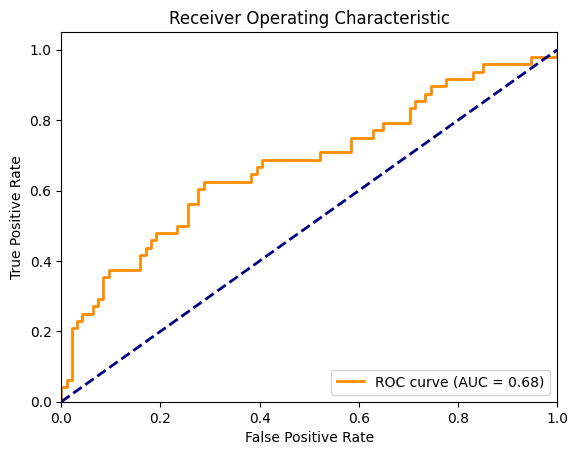

In [79]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# True labels and predicted probabilities
y_true = df_test["Pr[GP > 200]"]
y_score = result.predict(X)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**STORE MODEL IN AWS S3 BUCKET**

The code below will store the model in an AWS S3 bucket. I had to make a custom handler, since vetiver cannot handle sm.Logit models by default.

In [80]:
from vetiver.handlers.base import BaseHandler
import statsmodels.api as sm

#Need to create a custom handler for statsmodels Logit models, as the default handler cannot handle this type of model
class StatsmodelsLogitHandler(BaseHandler):
    def __init__(self, model, prototype_data):
        super().__init__(model, prototype_data)

    @staticmethod
    def model_type():
        return "statsmodels_logit"

    pip_name = "statsmodels"

    def handler_predict(self, input_data, check_prototype: bool):
        """
        Make predictions using a fitted statsmodels Logit model.

        Parameters
        ----------
        input_data:
            New data (e.g., from API)
        check_prototype: bool
            Whether to check data shape

        Returns
        -------
        Prediction array from model.predict
        """
        # Add constant to match model spec
        input_data_const = sm.add_constant(input_data, has_constant='add')
        prediction = self.model.predict(input_data_const)
        return prediction

In [81]:
from pins import board_s3
from vetiver import vetiver_pin_write
from vetiver import VetiverModel

#Store the model in an S3 bucket:

board = board_s3("devakshah-stat468-models", allow_pickle_read=True)

custom_handler = StatsmodelsLogitHandler(result, prototype_data=X)
vetiver_model = VetiverModel(custom_handler, model_name="my_logit_model", description="Logistic regression", handler=custom_handler)

vetiver_pin_write(board, vetiver_model)

Model Cards provide a framework for transparent, responsible reporting. 
 Use the vetiver `.qmd` Quarto template as a place to start, 
 with vetiver.model_card()
Writing pin:
Name: 'my_logit_model'
Version: 20250805T110701Z-c2663


The code below is used to store other data in the AWS S3 bucket. This data will be imported into the Shiny App.

In [82]:
#Storing Other Data used by app / report in s3 bucket:
board = board_s3("devakshah-stat468-models", allow_pickle_read=True)
board.pin_write(df, name="regression_input_data", type="csv")

Writing pin:
Name: 'regression_input_data'
Version: 20250805T110702Z-466c5


Meta(title='regression_input_data: a pinned 484 x 14 DataFrame', description=None, created='20250805T110702Z', pin_hash='466c5a8e368daea5', file='regression_input_data.csv', file_size=43463, type='csv', api_version=1, version=Version(created=datetime.datetime(2025, 8, 5, 11, 7, 2, 267846), hash='466c5a8e368daea5'), tags=None, name='regression_input_data', user={}, local={})